In [1]:
import sys
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from copy import copy
from qca import QCA
from figures import names
from core1d import rule_hamiltonian
from states import make_state
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from numpy.linalg import multi_dot
from scipy.linalg import expm
from matrix import op_at, dagger
from measures import expectation
from figures import colors
from time import time
%matplotlib inline

In [2]:
import matrix
import qca
import states
import figures
from importlib import reload
reload(matrix)
reload(qca)
reload(states)
reload(figures)

from figures import names, colors
from states import make_state
from measures import get_rhoj, get_expectation
from matrix import ops


# 2-qubit ferromagnetic state at 45 degrees
psi = make_state(2, "ot45")

# verify
rhoj = get_rhoj(psi)
X = get_expectation(rhoj, ops["X"])
Y = get_expectation(rhoj, ops["Y"])
Z = get_expectation(rhoj, ops["Z"])
print(X)
print(Y)
print(Z)
np.arccos(Z/np.sqrt(X*X+Z*Z)) * 180/np.pi

[0.70710678 0.70710678]
[0. 0.]
[0.70710678 0.70710678]


array([45., 45.])

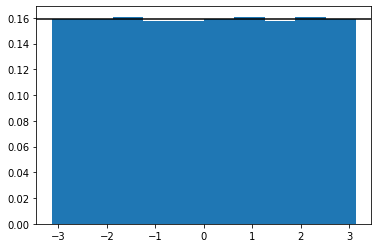

In [3]:
# Haar random matrix
from matrix import haar, isU, ops
U = haar(1000) # 1000-dimensional array
eigs = np.linalg.eigvals(U)

# haar random matrix is unitary and has eigenvalues exp(i theta) 
# with theta unifromly distributed 
phs = np.angle(eigs)
plt.hist(phs, density="True")
plt.axhline(1/(2*np.pi), c="k")

In [5]:
%%time
der = r"/home/lhillber/documents/research/cellular_automata/qca/data/"
from qca import QCA, QCA_from_file, main_from_params_list

run = True

Rs = [1, 6, 9, 14, 13]
Ls = [6,8,10,12,14,16,18]
ICs = ["ot45"]

params_template = dict(
              T=100.0,
              L=20,
              dt=1.0,
              r=1,
              V="A",
              BC="0",
              E=0.0,
              N=100,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)

params_list = []
Qs = np.zeros((len(ICs), len(Rs), len(Ls)), dtype="object")
for ICi, IC in enumerate(ICs):
    for Ri, R in enumerate(Rs):
        for Li, L in enumerate(Ls):
            params = copy(params_template)
            params["R"] = R
            params["IC"] = IC
            params["L"] = L
            params_list.append(params)
            if not run:
                Q = QCA(params, der=der)
                Qs[ICi, Ri, Li] = Q
                
print(len(params_list))           
if run:
    main_from_params_list(params_list,
                          tasks=["rhoj", "rhojk", "ebipart", "rho3", "rho4", "rho5"], 
                          der=der, 
                          nprocs=-1,
                          recalc=False)

35
CPU times: user 908 ms, sys: 360 ms, total: 1.27 s
Wall time: 6h 10min 49s


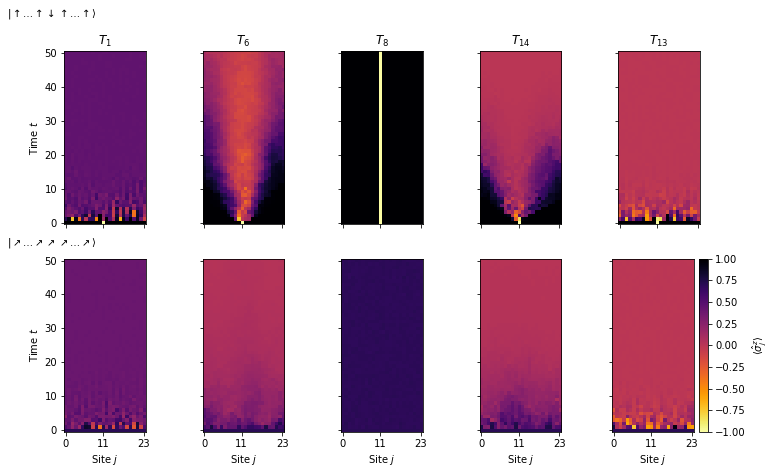

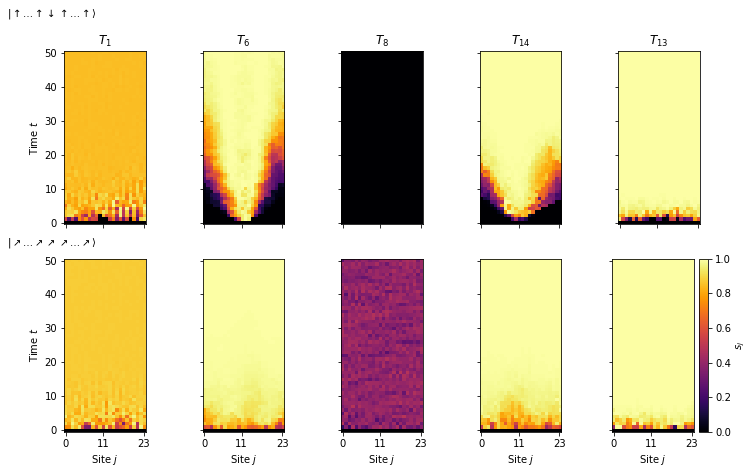

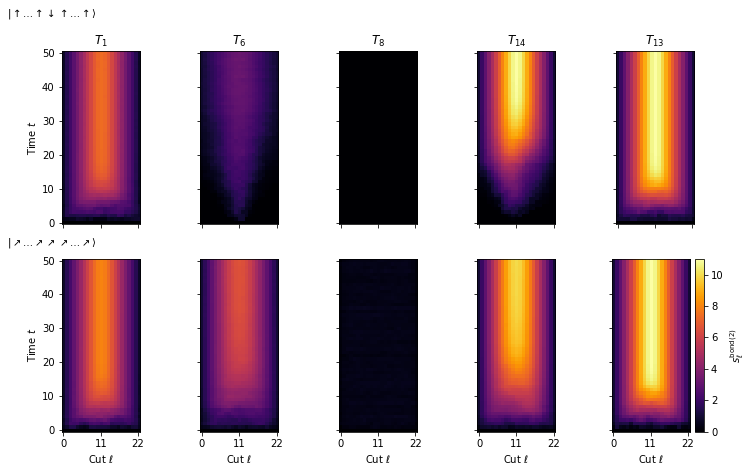

In [75]:
for measi, meas in enumerate(["exp_Z", "s_1", "sbipart_2"]):
    fig, axs = plt.subplots(2, len(Rs), figsize=(12, 7))
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            Q = Qs[ICi, Ri, -1]
            ax = axs[ICi, Ri]
            if meas.split("_")[0] == "s":
                cmap = "inferno"
                vmin=0
                vmax=1
                xticks = [0, 11, 23]
            if meas.split("_")[0] == "sbipart":
                cmap = "inferno"
                vmin=0
                vmax=11
                xticks = [0, 11, 22]
            
            if meas.split("_")[0] == "exp":
                cmap = "inferno_r"
                vmin=-1
                vmax=1
                xticks = [0, 11, 23]
                
            if Ri == len(Rs) -1 and ICi == len(ICs) - 1:
                cbar = True
            else:
                cbar = False
            Q.plot(meas, ax=ax, cbar=cbar, tmax=50, cmap=cmap, vmin=vmin, vmax=vmax)
            if Ri != 0:
                ax.set_ylabel("")
                ax.set_yticklabels([])
            if Ri==0:
                if IC == "c3_f1":
                    ax.text(-0.7, 1.2, r"$| \uparrow \ldots \uparrow \downarrow \uparrow \ldots \uparrow \rangle$", 
                            transform=ax.transAxes, ha="left")
                    
                elif IC == "ot45":
                    ax.text(-0.7, 1.08, r"$|\nearrow \ldots \nearrow \nearrow \nearrow \ldots \nearrow \rangle $", 
                            transform=ax.transAxes, ha="left")
                    
            if ICi != len(ICs)-1:
                ax.set_xlabel("")
                ax.set_xticks(xticks)
                ax.set_xticklabels([])
            else:
                ax.set_xticks(xticks)
            if ICi == 0:
                ax.set_title(r"$T_{%s}$"%R)
    plt.savefig(f"thermo-figures/{meas}_spacetime.pdf")
                

[<matplotlib.patches.Patch object at 0x7fa77d279400>, <matplotlib.patches.Patch object at 0x7fa77cd67a30>, <matplotlib.patches.Patch object at 0x7fa77cc51a00>, <matplotlib.patches.Patch object at 0x7fa77cc45e50>, <matplotlib.patches.Patch object at 0x7fa77cc45610>]


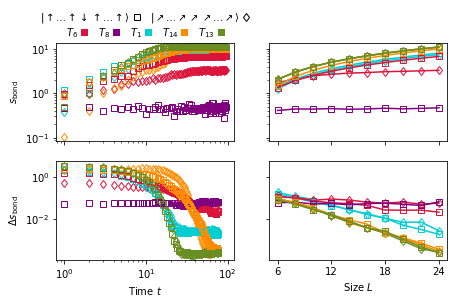

In [114]:
measures = ["sbisect_2", "Dsbisect_2"]
fig, axs = plt.subplots(len(measures), 2, figsize=(7, 4), sharey="row", sharex="col")
for measi, meas in enumerate(measures):
    for ICi, (IC, marker) in enumerate(zip(ICs[:], ["d", "s"][:])):
        for Ri, R in enumerate(Rs):
            ms = []
            for Li, L in enumerate(Ls):
                Q = Qs[ICi, Ri, Li]
                m = Q.get_measure(meas)
                if len(m.shape) == 2:
                         m = m[:, int(L)]
                ms.append(m[3*Q.L:].mean())
            
            ts = Q.ts[:len(m)]
            mask = ts<Q.L*4
            mask[0] = False
            axs[measi, 0].plot(ts[mask], m[mask], mfc="none", c=colors[R], mec=colors[R], ls="none", marker=marker)
            axs[measi, 1].plot(Ls, ms,  mfc="none", c=colors[R], mec=colors[R], ls=ls, marker=marker)
            
            axs[measi, 0].set_xscale("log") 
            #axs[measi, 1].set_xscale("log") 
            axs[measi, 0].set_yscale("log")
            axs[measi, 0].set_ylabel(names[meas])
            axs[len(measures)-1, 0].set_xlabel(names["time"])
            axs[len(measures)-1, 1].set_xlabel(names["size"])
            axs[len(measures)-1, 1].set_xticks([6, 12, 18, 24])
legend_els = [Patch(facecolor=colors[R], edgecolor=None, label=names[R]) for R in [6, 8, 1, 14, 13]]

import matplotlib.lines as mlines

legend_els2 = [
    mlines.Line2D([0], [0], mec='k', mfc="none", marker='s', ls="none",
        label=r"$| \uparrow \ldots \uparrow \downarrow \uparrow \ldots \uparrow \rangle$"),
    mlines.Line2D([0], [0],  mec='k', mfc="none", marker='d', ls="none",
        label=r"$|\nearrow \ldots \nearrow \nearrow \nearrow \ldots \nearrow \rangle $")]
print(legend_els)
axs[0,0].legend(handles=legend_els,
                        loc="center",
                        bbox_to_anchor=[0.5, 1.1],
                        frameon=False,
                        markerfirst=False,
                        ncol=5,
                        columnspacing=1,
                        handletextpad=0.3,
                        handlelength=0.7)
axs[1,0].legend(handles=legend_els2,
                        loc="center",
                        bbox_to_anchor=[0.5, 2.45],
                        frameon=False,
                        markerfirst=False,
                        ncol=5,
                        columnspacing=1,
                        handletextpad=0.3,
                        handlelength=0.7)

plt.savefig("thermo-figures/random-V_bond-entropy.pdf")

In [88]:
colors

{6: 'crimson',
 1: 'darkturquoise',
 14: 'darkorange',
 13: 'olivedrab',
 4: 'darkgoldenrod',
 26: 'olivedrab',
 15: 'k',
 8: 'purple',
 'R': 'k'}

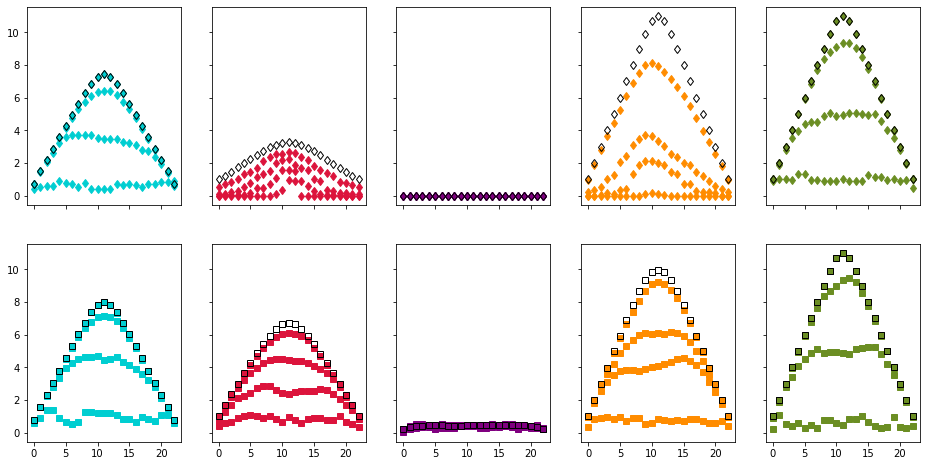

In [29]:
fig, axs = plt.subplots(len(ICs),len(Rs), figsize=(16, 8), sharey=True, sharex=True)
for ICi, (IC, marker) in enumerate(zip(ICs, ["d", "s"])):
    for Ri, R in enumerate(Rs):
        ax = axs[ICi, Ri]
        for L, ls in zip([24], ["-"]):
            for t in [1, L/4, L/2, L, -1]:
                Li = Ls.index(L)
                Q = Qs[ICi, Ri, Li]
                if t == -1:
                    m = np.mean(Q.get_measure("sbipart_2")[50:], axis=0)
                    ax.plot(m, mec="k", mfc="none", marker=marker, ls="none", lw=1)


                else:
                    m = np.mean(Q.get_measure("sbipart_2")[int(t):int(t)+1], axis=0)
                    ax.plot(m, color=colors[R], marker=marker, ls="none", lw=1)

                #ax.set_xscale("log")
                #ax.set_yscale("log")

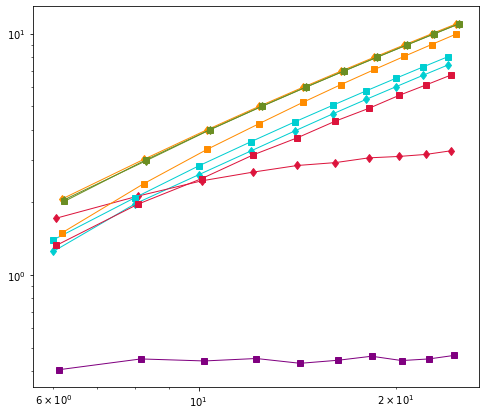

In [30]:
fig, axs = plt.subplots(1,1, figsize=(8, 7))
measures = ["sbisect_2", "exp_Z"]
fig, axs = plt.subplots(len(ICs),len(Rs), figsize=(16, 8), sharey=True, sharex=True)
for ICi, (IC, marker) in enumerate(zip(ICs, ["d", "s"])):
    ax = axs
    for Ri, R in enumerate(Rs):
        ms = []
        for Li, L in enumerate(Ls):
            Q = Qs[ICi, Ri, Li]
            m = Q.get_measure("sbisect_2")[50:].mean()
            ms.append(m)
        ax.plot(np.array(Ls)*(1+Ri/100
                             ), ms, color=colors[R], marker=marker, ls="-", lw=1)
        
        ax.set_xscale("log")
        ax.set_yscale("log")